<a href="https://www.kaggle.com/code/xuanbao01/khaipha-btl?scriptVersionId=191340883" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
train_df.loc[train_df["Phone Service"] == "No", "Avg Monthly Long Distance Charges"] = train_df.loc[train_df["Phone Service"] == "No", "Avg Monthly Long Distance Charges"].fillna(0)
train_df.loc[train_df["Internet Service"] == "No", "Avg Monthly GB Download"] = train_df.loc[train_df["Internet Service"] == "No", "Avg Monthly GB Download"].fillna(0)

test_df.loc[test_df["Phone Service"] == "No", "Avg Monthly Long Distance Charges"] = test_df.loc[test_df["Phone Service"] == "No", "Avg Monthly Long Distance Charges"].fillna(0)
test_df.loc[test_df["Internet Service"] == "No", "Avg Monthly GB Download"] = test_df.loc[test_df["Internet Service"] == "No", "Avg Monthly GB Download"].fillna(0)

train_df.info()


# Import thư viện

In [ ]:
import pandas as pd
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sklearn
from collections import Counter

from sklearn.feature_selection import SelectKBest, chi2

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

# model
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


import scikitplot as skplt




# Load dữ liệu

In [ ]:
train_df = pd.read_csv("/kaggle/input/telecom/5.telecom_train.csv")
test_df = pd.read_csv("/kaggle/input/telecom/4.telecom_test.csv")

train_df = train_df.drop(["Churn Category", "Churn Reason"], axis=1)
test_df = test_df.drop(["Churn Category", "Churn Reason"], axis=1)

# 2. Hiểu dữ liệu

## 2.1 Phân tích chung

### 2.1.1 Phân tích đơn biến

In [72]:
train_df.describe()

,Age,Number of Dependents,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
count,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,4974.000000,4306.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000
mean,46.512909,0.470727,93496.518364,36.215866,-119.767786,1.952000,32.263091,25.517214,26.221087,63.640282,2273.396062,1.834020,6.829091,749.343147,3027.734280
std,16.765165,0.963820,1852.150700,2.473192,2.157951,2.989505,24.551308,14.272308,19.650616,31.265938,2265.267074,7.643498,24.981169,845.685062,2864.034779
min,19.000000,0.000000,90001.000000,32.555828,-124.301372,0.000000,1.000000,1.010000,2.000000,-10.000000,18.800000,0.000000,0.000000,0.000000,21.400000
25%,32.000000,0.000000,92105.750000,33.994638,-121.809955,0.000000,9.000000,13.162500,12.000000,30.337500,384.875000,0.000000,0.000000,67.870000,593.162500
50%,46.000000,0.000000,93522.500000,36.245926,-119.636676,0.000000,29.000000,25.620000,21.000000,70.100000,1391.950000,0.000000,0.000000,403.550000,2105.870000
75%,60.000000,0.000000,95329.250000,38.169605,-117.980524,3.000000,55.000000,38.050000,30.000000,89.800000,3779.737500,0.000000,0.000000,1187.430000,4784.470000
max,80.000000,9.000000,96148.000000,41.962127,-114.192901,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

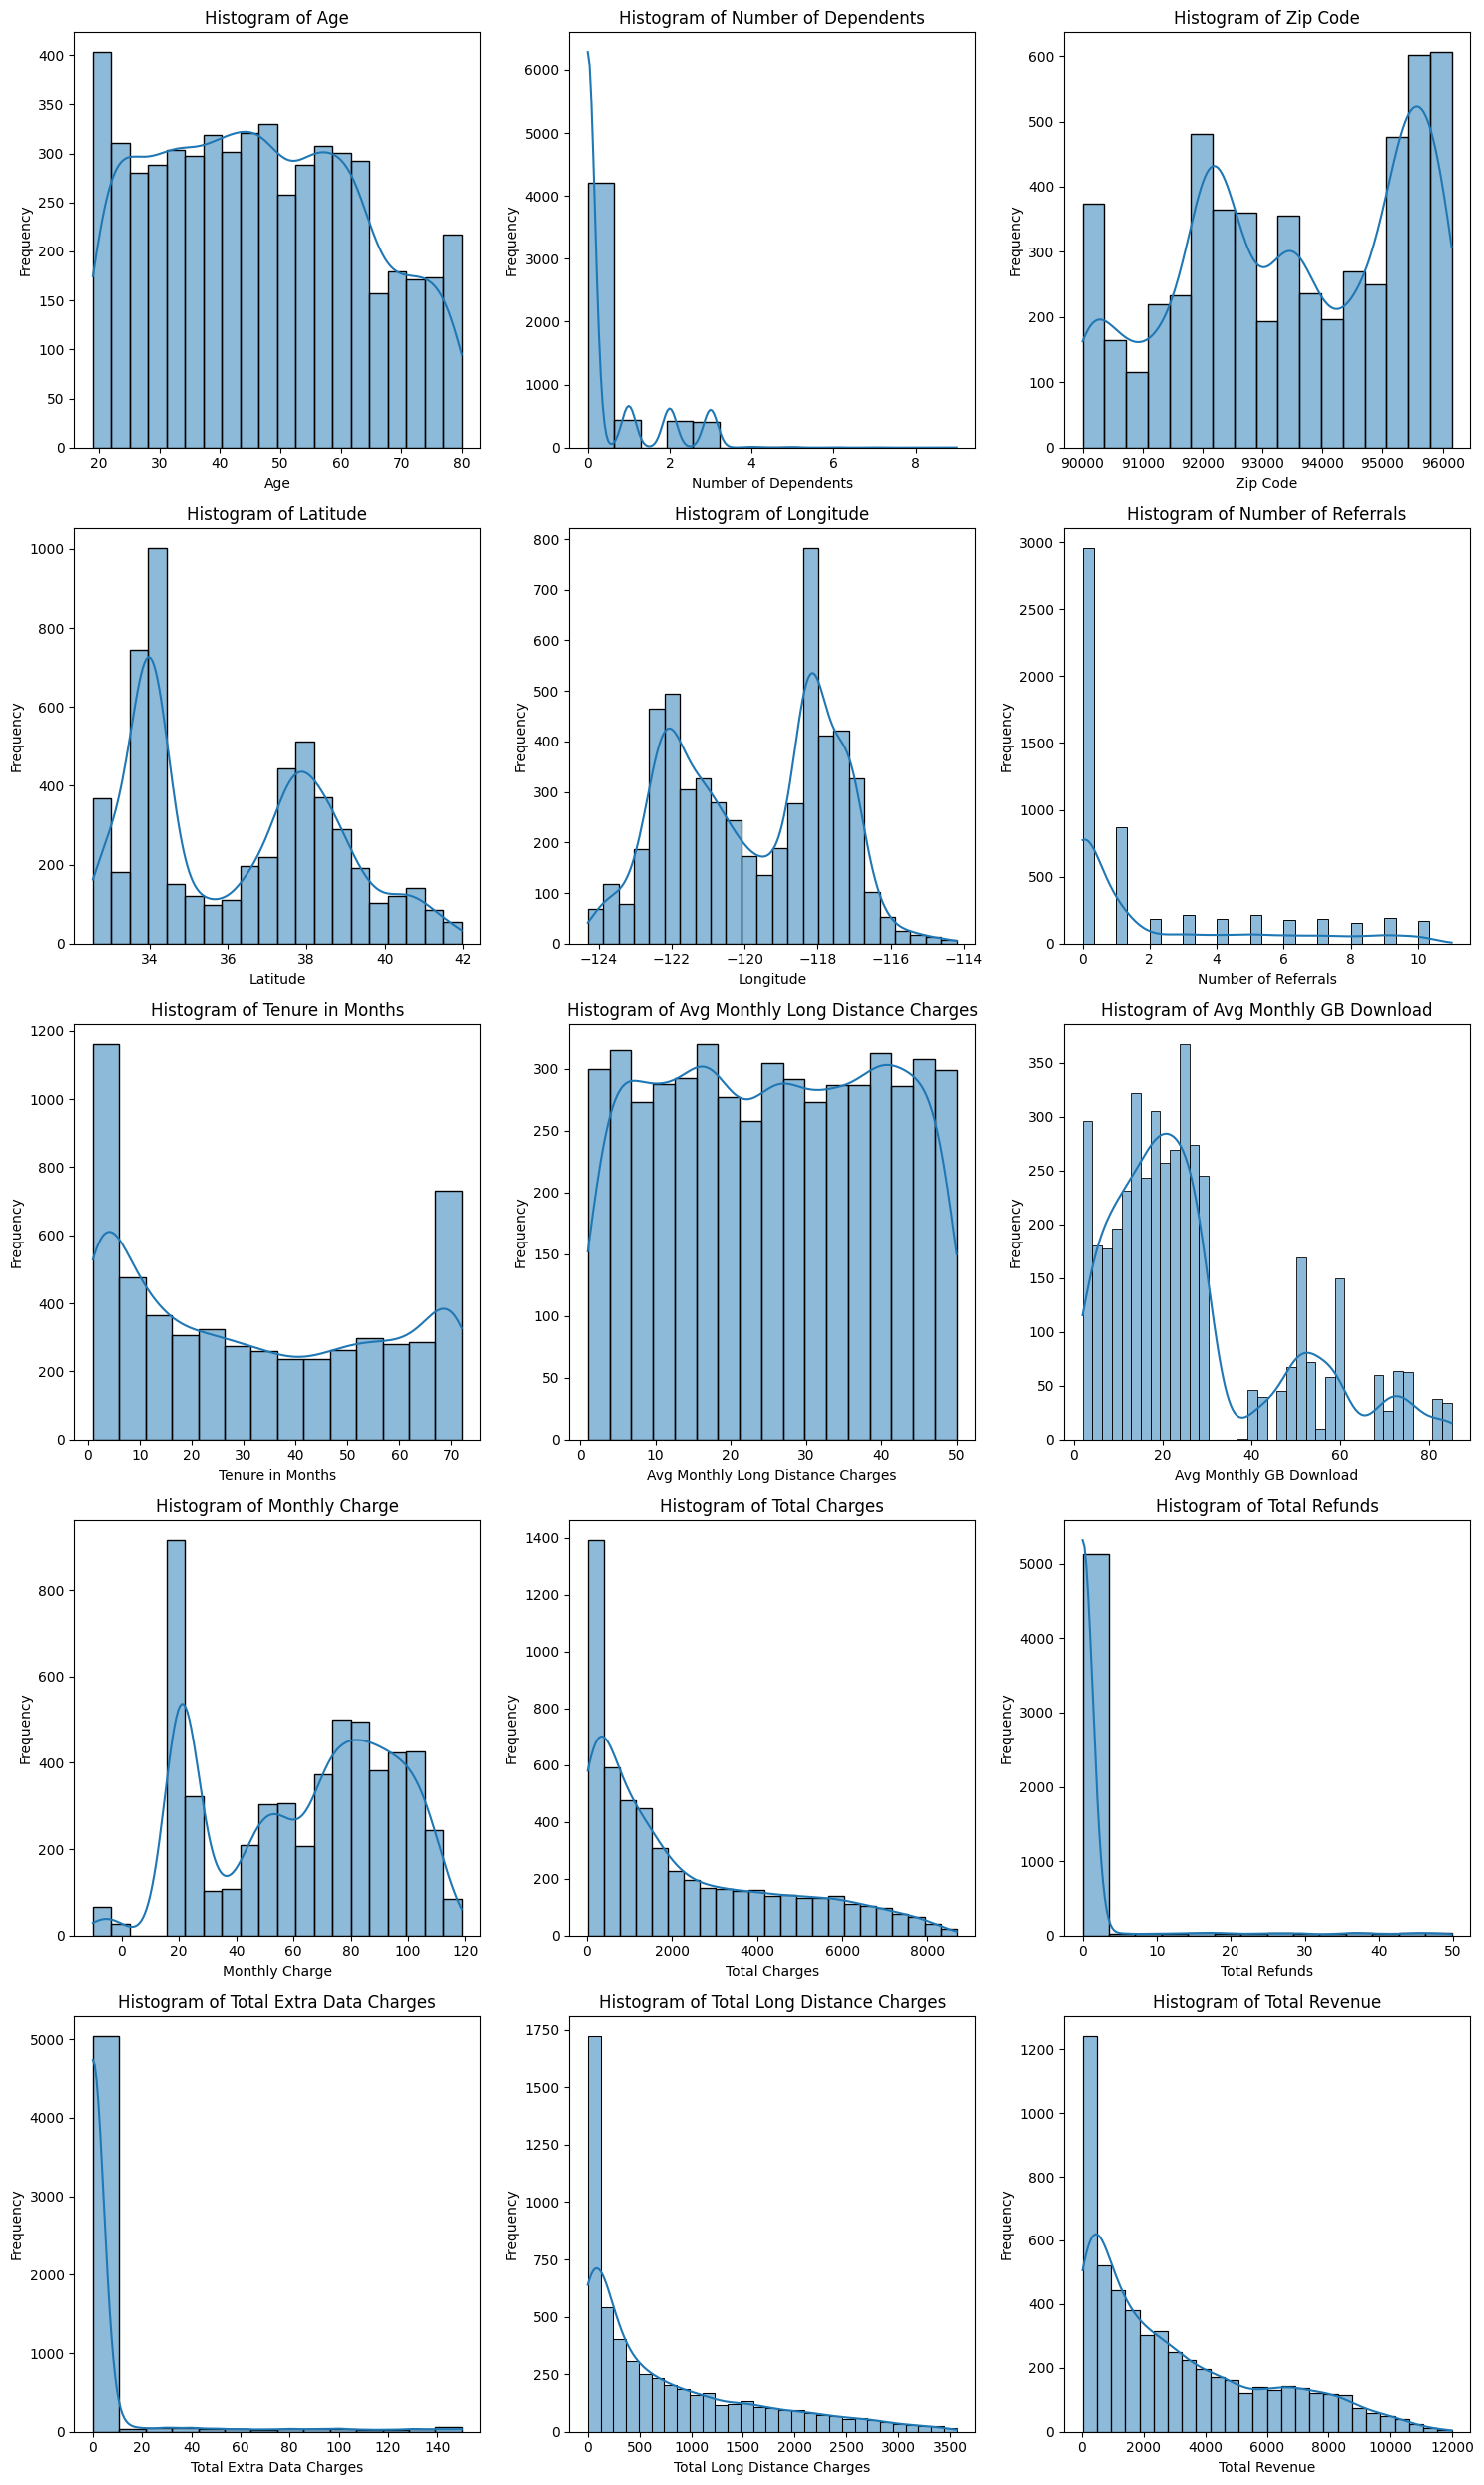

In [73]:
# numerical features
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Chọn các cột kiểu số (numeric)
numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns

# Xác định số lượng biến số
num_vars = len(numeric_columns)
num_cols = 3  # Số cột của lưới
num_rows = (num_vars + num_cols - 1) // num_cols  # Số hàng của lưới

# Tạo các biểu đồ con
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Duyệt qua các biến số và vẽ histogram
for i, column in enumerate(numeric_columns):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(train_df[column].dropna(), kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Histogram of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')

# Xóa các biểu đồ phụ nếu số biến không đủ để lấp đầy toàn bộ lưới
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j // num_cols, j % num_cols])

plt.tight_layout()
plt.show()


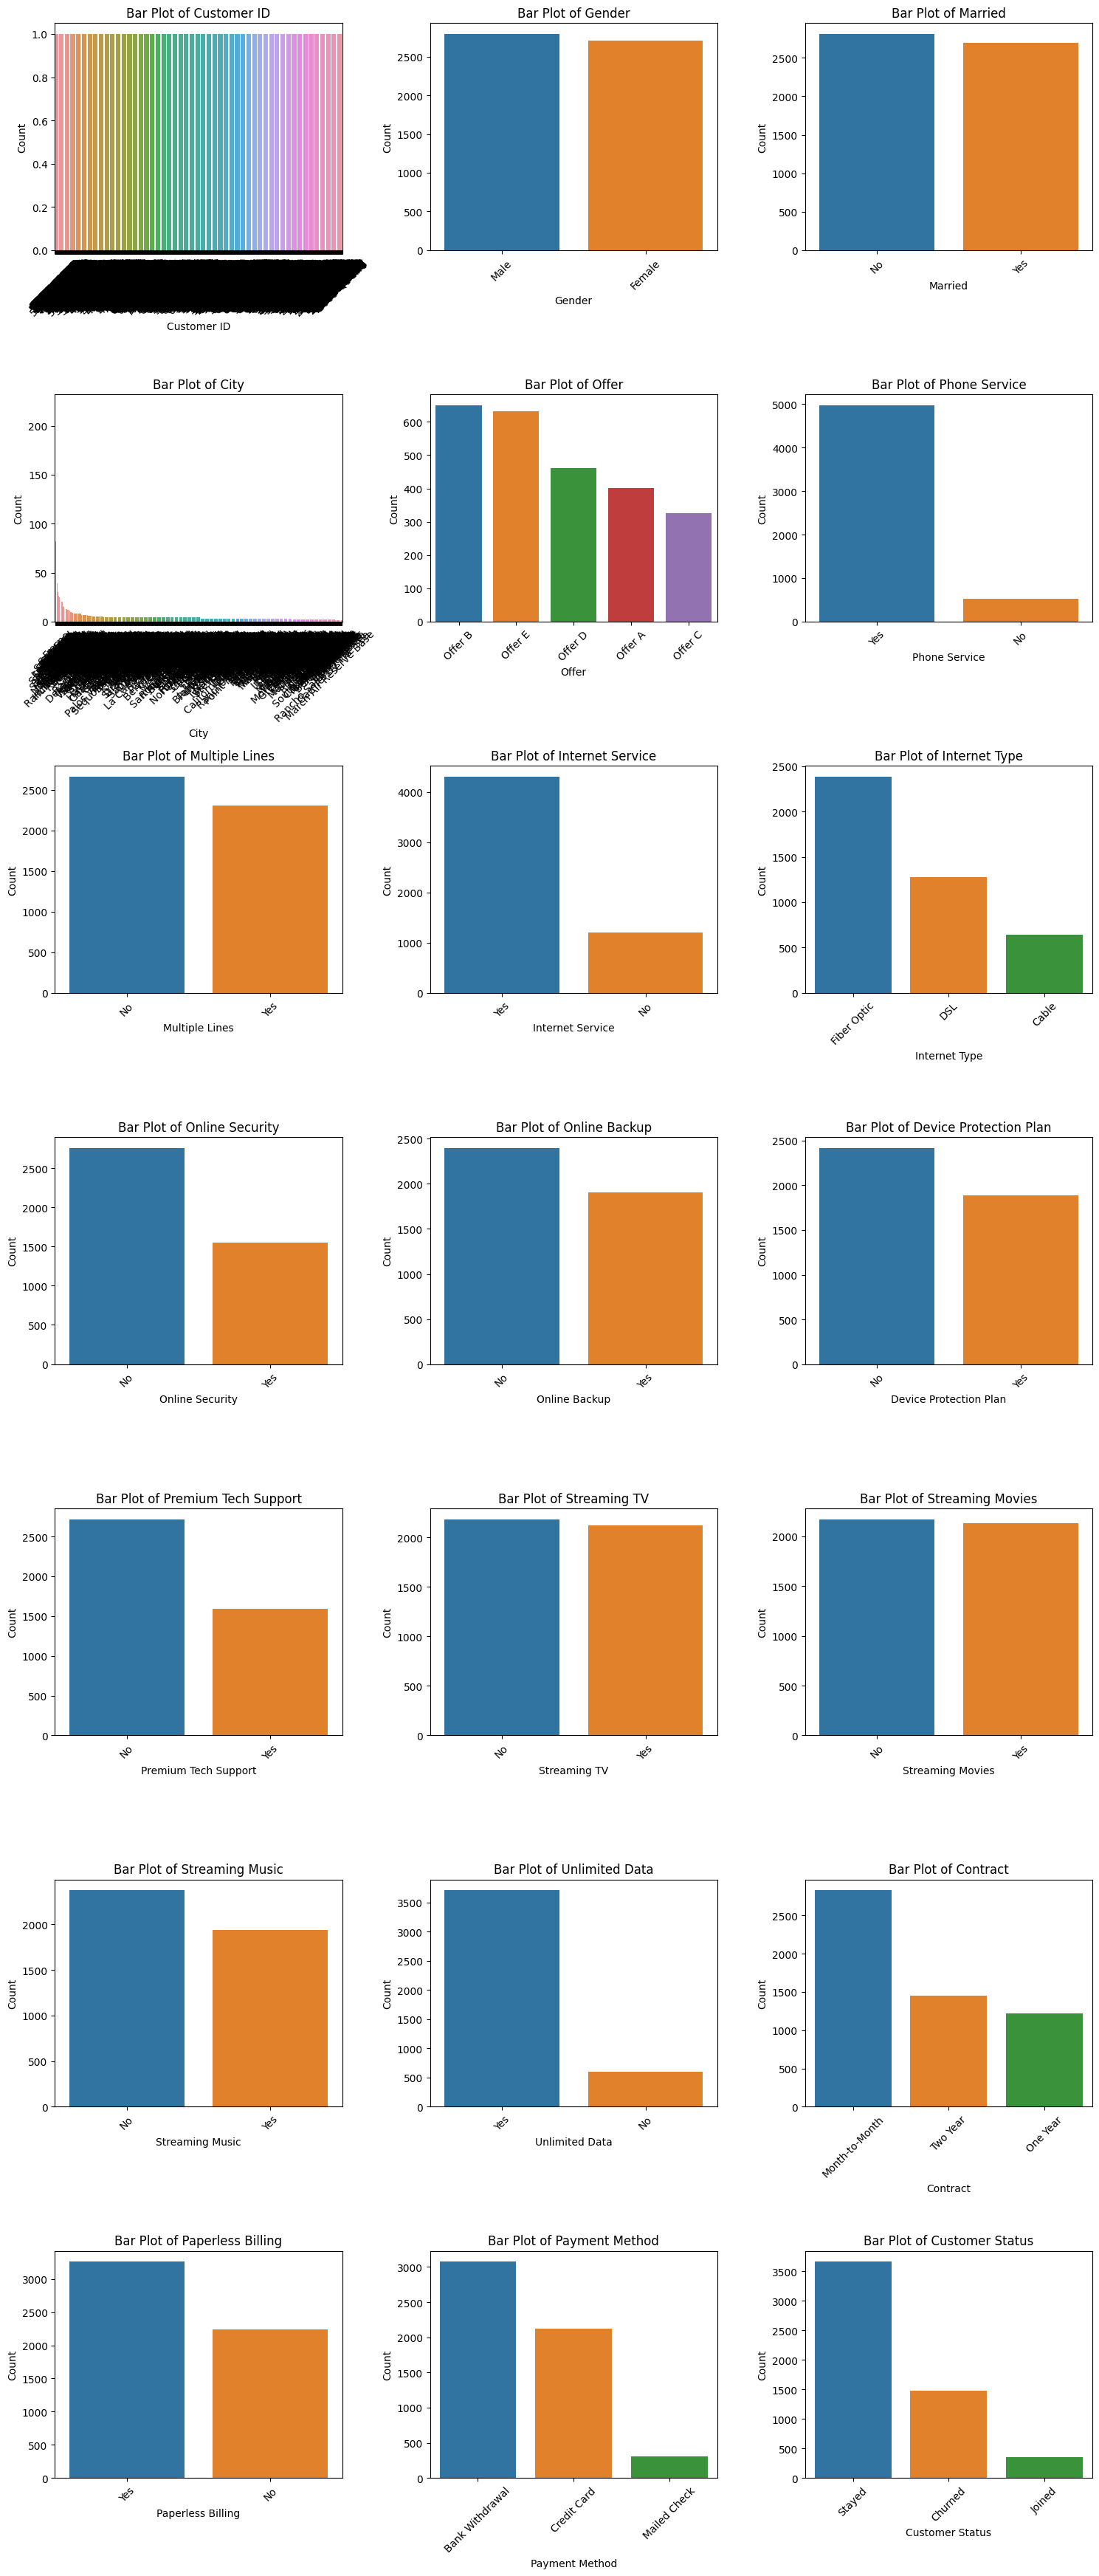

In [74]:
# categorical feature
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Giả sử train_df đã được tải vào
# Chọn các cột kiểu object (categorical)
categorical_columns = train_df.select_dtypes(include=['object']).columns

# Xác định số lượng biến phân loại
num_vars = len(categorical_columns)
num_cols = 3  # Số cột của lưới
num_rows = (num_vars + num_cols - 1) // num_cols  # Số hàng của lưới

# Tạo các biểu đồ con
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Duyệt qua các biến phân loại và vẽ biểu đồ
for i, column in enumerate(categorical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.countplot(data=train_df, x=column, order=train_df[column].value_counts().index, ax=axes[row, col])
    axes[row, col].set_title(f'Bar Plot of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Count')
    axes[row, col].tick_params(axis='x', rotation=45)

# Xóa các biểu đồ phụ nếu số biến không đủ để lấp đầy toàn bộ lưới
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j // num_cols, j % num_cols])

plt.tight_layout()
plt.show()


### 2.1.2 Phân tích đa biến

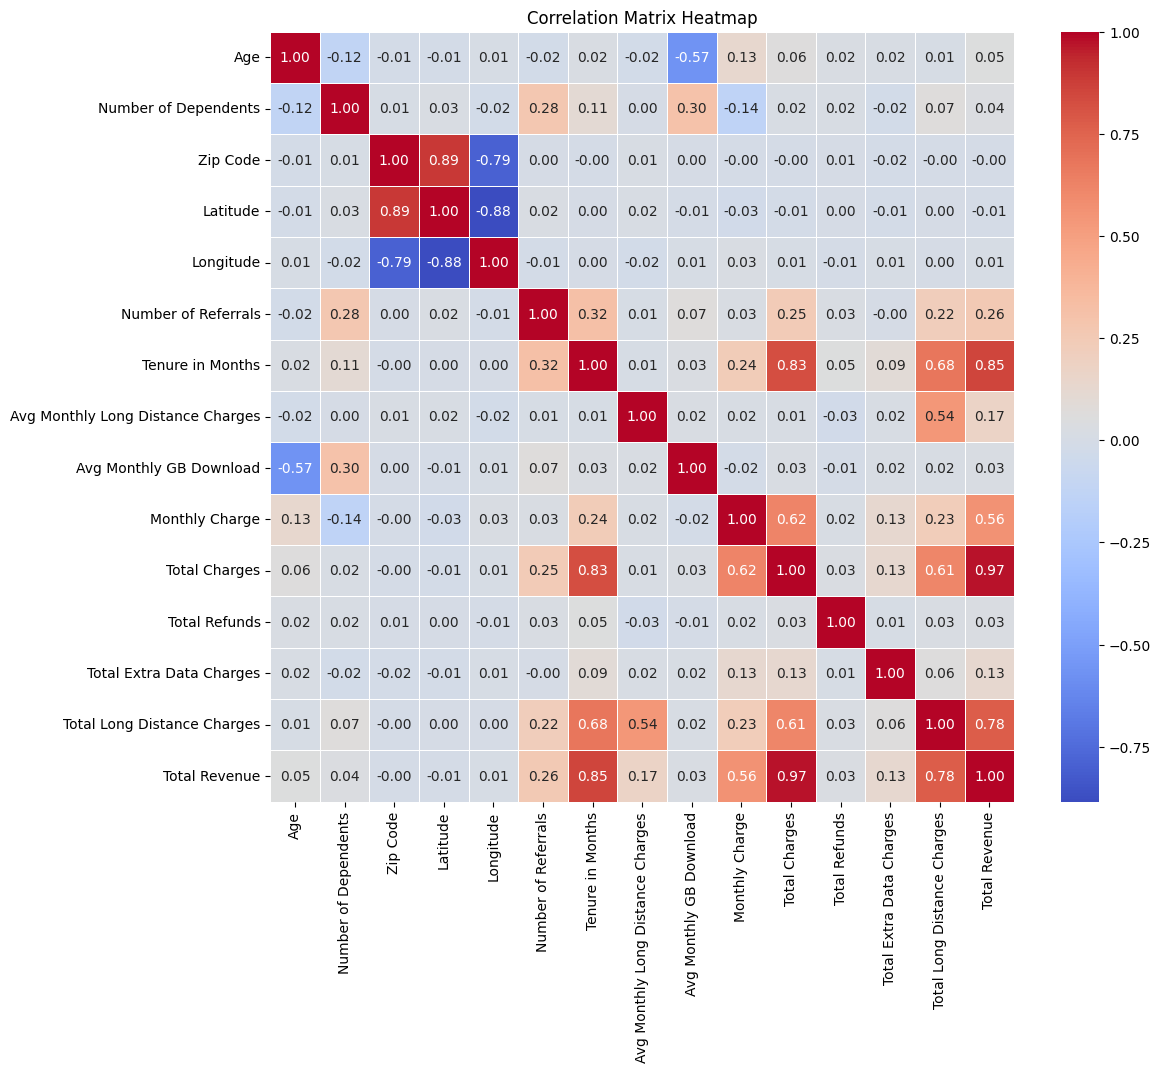

In [76]:
import pandas as pd

# Ma trận tương quan
corr_matrix = train_df[numeric_columns].corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

<Axes: xlabel='Tenure in Months', ylabel='Total Revenue'>

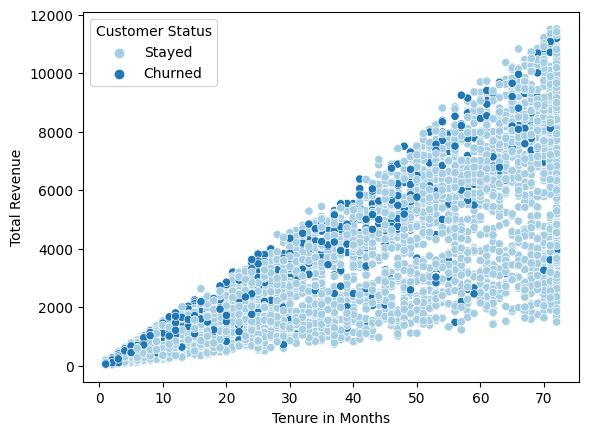

In [89]:
#phan bo perimeter voi moi class
sns.scatterplot(x=train_df['Tenure in Months'],y=train_df["Total Revenue"],hue=train_df["Customer Status"],palette='Paired')

<Axes: xlabel='Monthly Charge', ylabel='Total Charges'>

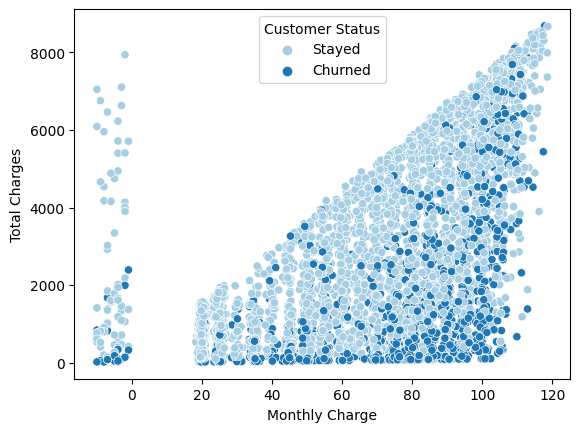

In [91]:
#phan bo perimeter voi moi class
sns.scatterplot(x=train_df['Monthly Charge'],y=train_df["Total Charges"],hue=train_df["Customer Status"],palette='Paired')

# 3. Chuẩn bị dữ liệu

## 3.1 Làm sạch dữ liệu

### 3.1.1 Xử lý dữ liệu bị thiếu

In [77]:
# Filter the DataFrame to exclude rows where "Customer Status" is "Joined"
train_df = train_df[train_df["Customer Status"] != "Joined"]
train_df.reset_index(drop=True, inplace=True)

# Separate numerical and categorical columns
category_cols = [cname for cname in train_df.columns if train_df[cname].dtype == "object" and cname != "Customer Status"]
numerical_cols = [cname for cname in train_df.columns if train_df[cname].dtype in ['int64', 'float64']]

# Calculate mode and mean for different groups in the train set
mode_stayed = train_df[train_df["Customer Status"] == "Stayed"].mode().iloc[0]
mode_churned = train_df[train_df["Customer Status"] == "Churned"].mode().iloc[0]
mean_stayed = train_df[train_df["Customer Status"] == "Stayed"][numerical_cols].mean()
mean_churned = train_df[train_df["Customer Status"] == "Churned"][numerical_cols].mean()

# Fill missing values based on the Customer Status in the train set
train_df.loc[train_df["Customer Status"] == "Stayed", numerical_cols] = train_df.loc[train_df["Customer Status"] == "Stayed", numerical_cols].fillna(mode_stayed)
train_df.loc[train_df["Customer Status"] == "Churned", numerical_cols] = train_df.loc[train_df["Customer Status"] == "Churned", numerical_cols].fillna(mode_churned)
train_df.loc[train_df["Customer Status"] == "Stayed", category_cols] = train_df.loc[train_df["Customer Status"] == "Stayed", category_cols].fillna(mode_stayed)
train_df.loc[train_df["Customer Status"] == "Churned", category_cols] = train_df.loc[train_df["Customer Status"] == "Churned", category_cols].fillna(mode_churned)


# Repeat the process for the test set
test_df = test_df[test_df["Customer Status"] != "Joined"]
test_df.reset_index(drop=True, inplace=True)

test_df_ori = test_df

mode_stayed = test_df[test_df["Customer Status"] == "Stayed"].mode().iloc[0]
mode_churned = test_df[test_df["Customer Status"] == "Churned"].mode().iloc[0]
mean_stayed = test_df[test_df["Customer Status"] == "Stayed"][numerical_cols].mean()
mean_churned = test_df[test_df["Customer Status"] == "Churned"][numerical_cols].mean()

# Fill missing values based on the Customer Status in the test set
test_df.loc[test_df["Customer Status"] == "Stayed", numerical_cols] = test_df.loc[test_df["Customer Status"] == "Stayed", numerical_cols].fillna(mode_stayed)
test_df.loc[test_df["Customer Status"] == "Churned", numerical_cols] = test_df.loc[test_df["Customer Status"] == "Churned", numerical_cols].fillna(mode_churned)
test_df.loc[test_df["Customer Status"] == "Stayed", category_cols] = test_df.loc[test_df["Customer Status"] == "Stayed", category_cols].fillna(mode_stayed)
test_df.loc[test_df["Customer Status"] == "Churned", category_cols] = test_df.loc[test_df["Customer Status"] == "Churned", category_cols].fillna(mode_churned)



### 3.1.2 Xử lý giá trị ngoại lệ

In [78]:
import pandas as pd
from typing import Tuple
from sklearn.base import BaseEstimator, TransformerMixin

def find_boxplot_boundaries(col: pd.Series, whisker_coeff: float = 1.5) -> Tuple[float, float]:

    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - whisker_coeff * IQR
    upper = Q3 + whisker_coeff * IQR
    return lower, upper

class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, whisker_coeff: float = 1.5):
        self.whisker = whisker_coeff
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        self.lower, self.upper = find_boxplot_boundaries(X, self.whisker)
        return self

    def transform(self, X: pd.Series) -> pd.Series:
        return X.clip(self.lower, self.upper)

for seriesName, series in train_df.items():
    if series.dtype != "object":
        clipper = BoxplotOutlierClipper()
        train_df[seriesName] = clipper.fit_transform(series)

for seriesName, series in test_df.items():
    if series.dtype != "object":
        clipper = BoxplotOutlierClipper()
        test_df[seriesName] = clipper.fit_transform(series)     


## 3.2 Chuyển đổi dữ liệu

In [79]:

class_dict = {'Churned': 0, 'Stayed': 1}


X_train = train_df.drop("Customer Status", axis = 1)
y_train = train_df['Customer Status'].replace(class_dict)

X_test = test_df.drop("Customer Status", axis = 1)
y_test = test_df['Customer Status'].replace(class_dict)

/tmp/ipykernel_33/2750210209.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = train_df['Customer Status'].replace(class_dict)
/tmp/ipykernel_33/2750210209.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = test_df['Customer Status'].replace(class_dict)


### 3.2.1 Normalization

In [80]:
# normalization 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[numerical_cols])

X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


### 3.2.2 Encoding

In [ ]:
low_cardinality_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and 
                        X_train[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train[my_cols].copy()
X_test = X_test[my_cols].copy()

# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
X_test[object_cols] = ordinal_encoder.transform(X_test[object_cols])


In [81]:
# one hot encoding
from sklearn.preprocessing import OneHotEncoder

low_cardinality_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and 
                        X_train[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train[my_cols].copy()
X_test = X_test[my_cols].copy()

# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_test[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_test.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# Ensure all columns have string type
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)

X_train, X_test = OH_X_train, OH_X_valid


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## 4.3 Cân bằng dữ liệu

In [82]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SVMSMOTE


ros = SVMSMOTE()
X_train, y_train = ros.fit_resample(X_train, y_train)

### 3.2.3 Lựa chọn & trích xuất đặc trưng

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

def evaluate(model, x_test, y_test):
    pred = model.predict(x_test)
    acc = accuracy_score(y_test, pred)
    print("ACC: ", acc)
    print(classification_report(y_test,pred))
    return pred



# Apply SelectKBest to extract top k features
for i in range(5):
    print(i)
    selector = SelectKBest(chi2, k=i*10+2)
    X_train_selected = selector.fit_transform(X_train, y_train)

    selected_features = selector.get_support(indices=True)
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]
    rfc = RandomForestClassifier(n_estimators=110,max_features='sqrt',max_depth=40)

    rfc.fit(X_train_selected, y_train)
    pred = evaluate(rfc, X_test_selected, y_test)


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# Assuming train_df, X_train, y_train, X_test, y_test are already defined
def evaluate(model, x_test, y_test):
    pred = model.predict(x_test)
    acc = accuracy_score(y_test, pred)
    print("ACC: ", acc)
    print(classification_report(y_test,pred))
    return pred

def visualize_result(model, x_test, y_test):
    y_pred = model.predict(x_test)
    sns.heatmap(confusion_matrix(y_test,y_pred),cmap='Blues',annot=True,linewidths=2,linecolor='white')

# Train the LightGBM model
model_fi = lgb.LGBMClassifier()
model_fi.fit(X_train, y_train)

lgbm_scores = model_fi.feature_importances_

# Ensure the columns in X_train are being used for feature importance
lgbm_feats_score = list(zip(X_train.columns, lgbm_scores))
lgbm_feats_score.sort(key=lambda x: -x[1])
for j in range(57):
    print(j)
    lgbm_top_20feats = [i[0] for i in lgbm_feats_score][:j+1]
    
#     rfc = RandomForestClassifier(n_estimators=110,max_features='sqrt',max_depth=40)
#     rfc.fit(X_train[lgbm_top_20feats],y_train)
#     pred = evaluate(rfc, X_test[lgbm_top_20feats], y_test)
    sup = SVC(C=2,gamma='auto',kernel='rbf')
    sup.fit(X_train[lgbm_top_20feats],y_train)

    pred = evaluate(sup, X_test[lgbm_top_20feats], y_test)

#     clf = LogisticRegression(random_state=0).fit(X_train[lgbm_top_20feats], y_train)
#     evaluate(clf, X_train[lgbm_top_20feats], y_train)
#     visualize_result(clf, X_test[lgbm_top_20feats], y_test)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3663, number of negative: 3663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10728
[LightGBM] [Info] Number of data points in the train set: 7326, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0
ACC:  0.3981994459833795
              precision    recall  f1-score   support

           0       0.27      0.73      0.40       387
           1       0.74      0.28      0.40      1057

    accuracy                           0.40      1444
   macro avg       0.50      0.50      0.40      1444
weighted avg       0.61      0.40      0.40      1444

1
ACC:  0.6876731301939059
              precision    recall  f1-

In [84]:
from sklearn.decomposition import PCA
def evaluate(model, x_test, y_test):
    pred = model.predict(x_test)
    acc = accuracy_score(y_test, pred)
    print("ACC: ", acc)
    print(classification_report(y_test,pred))
    return pred

for i in range(57):
    pca = PCA(n_components=i+1)
    X_train_ = pca.fit_transform(X_train)
    X_test_ = pca.fit_transform(X_test)
    rfc = RandomForestClassifier(n_estimators=110,max_features='sqrt',max_depth=40)

    rfc.fit(X_train_, y_train)
    pred = evaluate(rfc, X_test_, y_test)


ACC:  0.5512465373961218
              precision    recall  f1-score   support

           0       0.33      0.64      0.43       387
           1       0.80      0.52      0.63      1057

    accuracy                           0.55      1444
   macro avg       0.56      0.58      0.53      1444
weighted avg       0.67      0.55      0.58      1444

ACC:  0.6475069252077562
              precision    recall  f1-score   support

           0       0.40      0.64      0.49       387
           1       0.83      0.65      0.73      1057

    accuracy                           0.65      1444
   macro avg       0.62      0.65      0.61      1444
weighted avg       0.72      0.65      0.67      1444

ACC:  0.5907202216066482
              precision    recall  f1-score   support

           0       0.33      0.52      0.40       387
           1       0.78      0.62      0.69      1057

    accuracy                           0.59      1444
   macro avg       0.55      0.57      0.55      1444

ACC:  0.9369806094182825
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       387
           1       0.96      0.95      0.96      1057

    accuracy                           0.94      1444
   macro avg       0.92      0.93      0.92      1444
weighted avg       0.94      0.94      0.94      1444



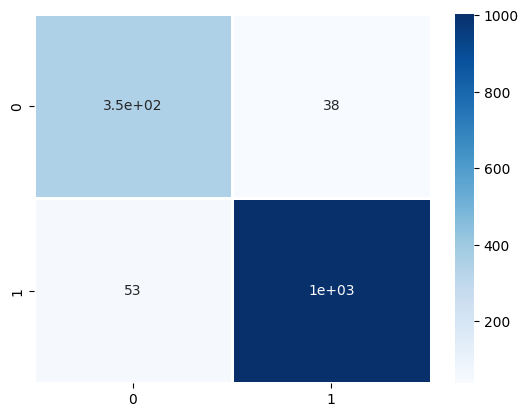

In [85]:
def evaluate(model, x_test, y_test):
    pred = model.predict(x_test)
    acc = accuracy_score(y_test, pred)
    print("ACC: ", acc)
    print(classification_report(y_test,pred))
    return pred



# Trực quan hoá một số thông tin
def visualize_result(model, x_test, y_test):
    y_pred = model.predict(x_test)
    sns.heatmap(confusion_matrix(y_test,y_pred),cmap='Blues',annot=True,linewidths=2,linecolor='white')
    
rfc = RandomForestClassifier(n_estimators=110,max_features='sqrt',max_depth=40)
rfc.fit(X_train,y_train)

pred_rfc = evaluate(rfc, X_test, y_test)
visualize_result(rfc, X_test, y_test)


ACC:  0.9141274238227147
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       387
           1       0.98      0.90      0.94      1057

    accuracy                           0.91      1444
   macro avg       0.88      0.92      0.90      1444
weighted avg       0.92      0.91      0.92      1444



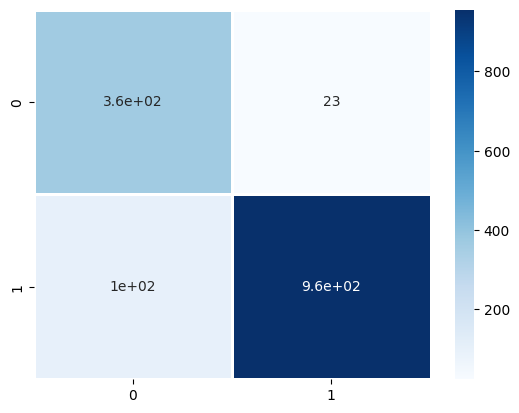

In [86]:
# Scaling the data using standard scaler
from sklearn.preprocessing import MinMaxScaler

sup = SVC(C=2,gamma='auto',kernel='rbf')
sup.fit(X_train,y_train)

pred_svm = evaluate(sup, X_test, y_test)
visualize_result(sup, X_test, y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ACC:  0.8995358995358995
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      3663
           1       0.91      0.88      0.90      3663

    accuracy                           0.90      7326
   macro avg       0.90      0.90      0.90      7326
weighted avg       0.90      0.90      0.90      7326



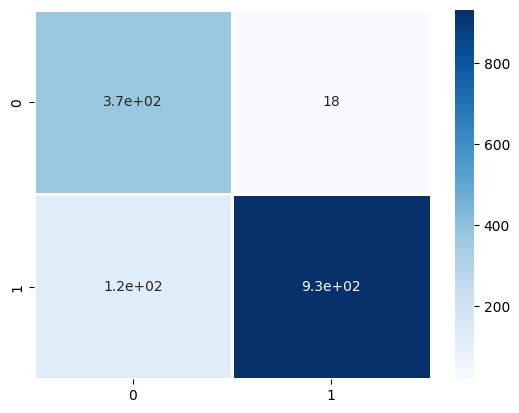

In [87]:
from sklearn.linear_model import LogisticRegression
    
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
pred_clf = evaluate(clf, X_train, y_train)
visualize_result(clf, X_test, y_test)

RandomForestClassifier wrong indices: [69, 92, 116, 133, 171, 180, 190, 217, 226, 313, 351, 373, 414, 489, 500, 511, 513, 549, 551, 555, 563, 678, 689, 702, 763, 768, 771, 831, 868, 871, 913, 924, 952, 958, 1016, 1088, 1138, 1223]
SVM wrong indices: [64, 91, 92, 133, 171, 190, 217, 226, 313, 414, 498, 511, 551, 555, 583, 689, 763, 768, 831, 868, 952, 1016, 1223]
Classifier wrong indices: [0, 8, 9, 11, 14, 19, 26, 27, 41, 46, 54, 58, 64, 65, 67, 70, 71, 77, 91, 92, 94, 95, 97, 108, 116, 122, 129, 133, 142, 151, 155, 158, 167, 171, 173, 178, 180, 205, 207, 211, 212, 217, 223, 226, 227, 233, 242, 255, 256, 262, 274, 277, 293, 294, 347, 351, 352, 355, 357, 370, 373, 390, 400, 405, 411, 414, 419, 423, 430, 432, 449, 452, 455, 458, 462, 482, 489, 492, 498, 499, 511, 513, 516, 534, 538, 539, 543, 545, 549, 551, 555, 560, 563, 569, 577, 583, 592, 596, 600, 601, 611, 631, 632, 650, 657, 664, 669, 671, 678, 679, 682, 694, 698, 699, 701, 702, 706, 710, 715, 718, 720, 726, 733, 740, 754, 760, 762,

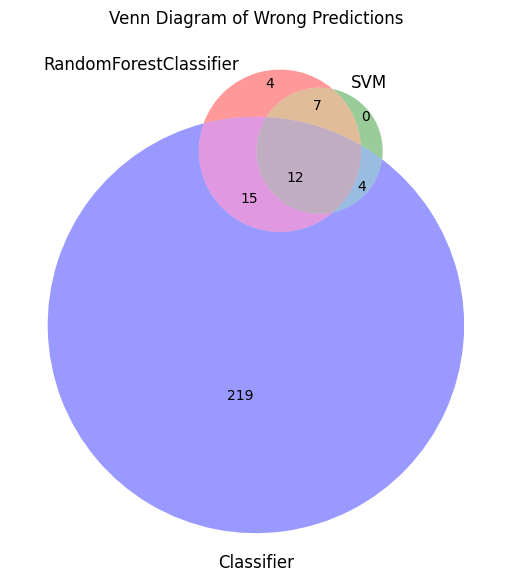

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Convert dataframes to numpy arrays
X_test_np = np.array(X_test)
test_df_np = np.array(test_df)
a = test_df_np[:, 35]

# Initialize lists to store indices of wrong predictions
wrong_index_rfc, wrong_index_svm, wrong_index_clf = [], [], []

# Populate the lists with indices where the prediction was wrong
for i in range(a.shape[0]):
    if pred_rfc[i] == 1 and a[i] == "Churned":
        wrong_index_rfc.append(i)
    if pred_svm[i] == 1 and a[i] == "Churned":
        wrong_index_svm.append(i)
    if pred_clf[i] == 1 and a[i] == "Churned":
        wrong_index_clf.append(i)

# Print the lists of wrong indices
print("RandomForestClassifier wrong indices:", wrong_index_rfc)
print("SVM wrong indices:", wrong_index_svm)
print("Classifier wrong indices:", wrong_index_clf)

# Create sets from the lists of indices
set_rfc = set(wrong_index_rfc)
set_svm = set(wrong_index_svm)
set_clf = set(wrong_index_clf)

# Plot Venn diagram
plt.figure(figsize=(10, 7))
venn3([set_rfc, set_svm, set_clf], ('RandomForestClassifier', 'SVM', 'Classifier'))
plt.title("Venn Diagram of Wrong Predictions")
plt.show()


In [ ]:
X_test_wrong_rfc = test_df_ori.loc[wrong_index_rfc]
X_test_wrong_rfc.head()
